In [12]:
spark.stop()

In [13]:
# import os
os.environ["PYSPARK_PYTHON"] = r"C:\Users\kompe\AppData\Local\Programs\Python\Python310\python.exe"
# os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\kompe\AppData\Local\Programs\Python\Python310\python.exe"

# os.environ["PYSPARK_PYTHON"] = r"C:\Users\saivi\AppData\Local\Programs\Python\Python310\python.exe"
# os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\saivi\AppData\Local\Programs\Python\Python310\python.exe"



In [14]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PythonCheck").getOrCreate()
print(spark.sparkContext.pythonExec)
rdd = spark.sparkContext.parallelize(range(10), 4)
print(rdd.map(lambda x: x ** 2).collect())

C:\Users\kompe\AppData\Local\Programs\Python\Python310\python.exe
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture

# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 4))

import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

import folium

np.set_printoptions(precision=4, suppress=True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed


In [16]:
spark = (SparkSession
         .builder
         .master("spark://10.0.0.225:7077")
         .appName("cluster-uber-trip-data")
         #.config("spark.pyspark.python", "C:/Users/saivi/AppData/Local/Programs/Python/Python310/python.exe")
         .getOrCreate())

In [17]:
import pandas as pd

# Use ISO-8859-1 encoding
df = pd.read_csv("C:/Users/saivi/spark-3.5.3-bin-hadoop3/merged.csv")

In [18]:
uber_df = spark.createDataFrame(df)
uber_df.show(10)

+----------------+-------+--------+------+
|              dt|    lat|     lon|  Base|
+----------------+-------+--------+------+
|7/1/2014 0:03:00|40.7586|-73.9706|B02512|
|7/1/2014 0:05:00|40.7605|-73.9994|B02512|
|7/1/2014 0:06:00| 40.732|-73.9999|B02512|
|7/1/2014 0:09:00|40.7635|-73.9793|B02512|
|7/1/2014 0:20:00|40.7204|-74.0047|B02512|
|7/1/2014 0:35:00|40.7487|-73.9869|B02512|
|7/1/2014 0:57:00|40.7444|-73.9961|B02512|
|7/1/2014 0:58:00|40.7132|-73.9492|B02512|
|7/1/2014 1:04:00| 40.759| -73.973|B02512|
|7/1/2014 1:08:00|40.7601|-73.9823|B02512|
+----------------+-------+--------+------+
only showing top 10 rows



In [8]:
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType, StringType

schema = StructType([
    StructField("dt", TimestampType(), nullable=False),   # Timestamp
    StructField("lat", DoubleType(), nullable=False),     # Latitude
    StructField("lon", DoubleType(), nullable=False),     # Longitude
    StructField("base", StringType(), nullable=True)      # Base identifier
])
uber_df.describe(["dt", "lat", "lon"]).show()

+-------+----------------+--------------------+-------------------+
|summary|              dt|                 lat|                lon|
+-------+----------------+--------------------+-------------------+
|  count|         1048575|             1048575|            1048575|
|   mean|            NULL|  40.739535827098635| -73.97283149502887|
| stddev|            NULL|0.040024489669462225|0.05822526662881502|
|    min|6/1/2014 0:00:00|             39.7214|            -74.826|
|    max|7/9/2014 9:59:00|             41.3413|           -72.3097|
+-------+----------------+--------------------+-------------------+



In [13]:
from pyspark.sql.functions import to_timestamp
uber_df = uber_df.withColumn("dt", to_timestamp("dt", "M/d/yyyy H:mm:ss"))

from pyspark.ml.feature import VectorAssembler

# Select the features for clustering
assembler = VectorAssembler(inputCols=["lat", "lon"], outputCol="features")
uber_df_features = assembler.transform(uber_df)

# Show the transformed data
uber_df_features.select("features").show(5, truncate=False)
from pyspark.ml.clustering import KMeans

# Define KMeans model
kmeans = KMeans(k=8, seed=3, featuresCol="features", predictionCol="cluster")

# Fit the model
kmeans_model = kmeans.fit(uber_df_features)

# Get cluster assignments
clustered_df = kmeans_model.transform(uber_df_features)

# Show a few rows with cluster assignments
clustered_df.select("lat", "lon", "cluster").show(10, truncate=False)


+------------------+
|features          |
+------------------+
|[40.7586,-73.9706]|
|[40.7605,-73.9994]|
|[40.732,-73.9999] |
|[40.7635,-73.9793]|
|[40.7204,-74.0047]|
+------------------+
only showing top 5 rows

+-------+--------+-------+
|lat    |lon     |cluster|
+-------+--------+-------+
|40.7586|-73.9706|0      |
|40.7605|-73.9994|0      |
|40.732 |-73.9999|2      |
|40.7635|-73.9793|0      |
|40.7204|-74.0047|2      |
|40.7487|-73.9869|0      |
|40.7444|-73.9961|2      |
|40.7132|-73.9492|6      |
|40.759 |-73.973 |0      |
|40.7601|-73.9823|0      |
+-------+--------+-------+
only showing top 10 rows



In [10]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas
clustered_pandas_df = clustered_df.select("lat", "lon", "cluster").toPandas()

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster_id in clustered_pandas_df["cluster"].unique():
    cluster_data = clustered_pandas_df[clustered_pandas_df["cluster"] == cluster_id]
    plt.scatter(cluster_data["lon"], cluster_data["lat"], label=f"Cluster {cluster_id}", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("KMeans Clustering of Uber Rides")
plt.legend()
plt.show()


NameError: name 'clustered_df' is not defined

    Latitude  Longitude
0  40.763108 -73.975209
1  40.792221 -73.162950
2  40.728072 -74.005045
3  40.754612 -73.604164
4  40.655572 -73.785567
5  40.985736 -73.791786
6  40.687343 -73.965215
7  40.784808 -73.887895


<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Cluster Centroids')

Text(0.5, 0, 'Latitude')

Text(0, 0.5, 'Longitude')

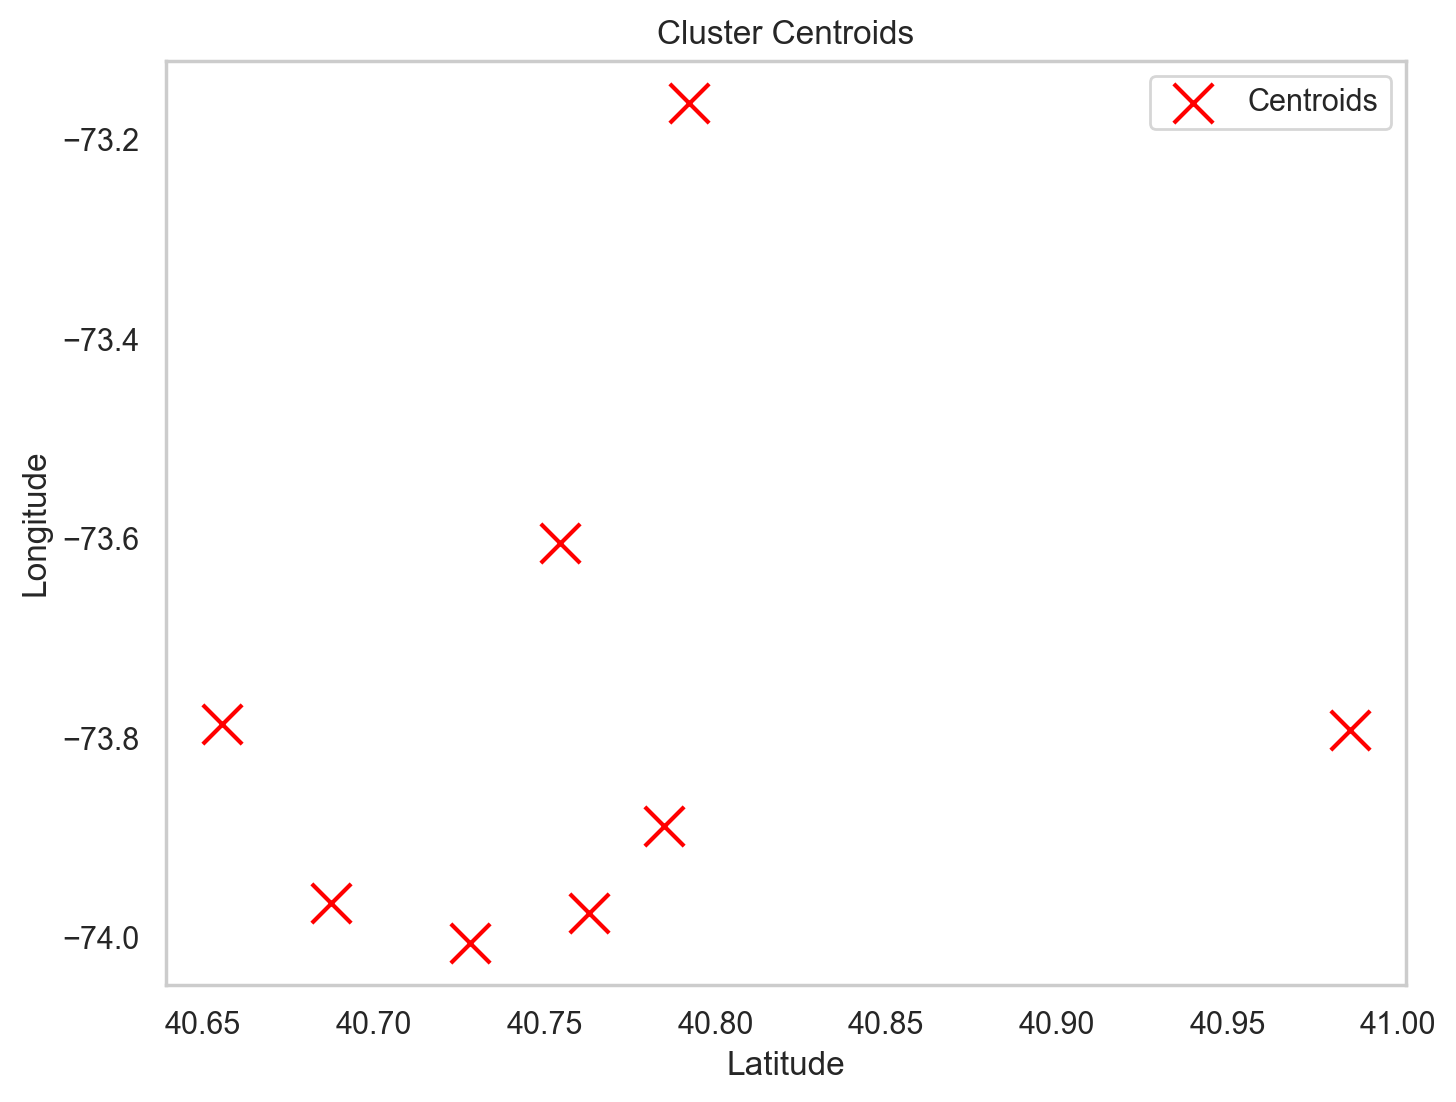

In [15]:
from pyspark.ml.clustering import KMeans
import pandas as pd
import matplotlib.pyplot as plt
import folium

# Get centroids of clusters
centroids = kmeans_model.clusterCenters()  # Extracting cluster centers
center_locations = pd.DataFrame(centroids, columns=["Latitude", "Longitude"])

# Display centroid dataframe
print(center_locations)

# Matplotlib Visualization of Centroids
plt.figure(figsize=(8, 6))
plt.scatter(center_locations["Latitude"], center_locations["Longitude"], marker='x', color='red', s=200, label="Centroids")
plt.title("Cluster Centroids")
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.legend()
plt.grid()
plt.show()

# Converting centroids to list
centroid_list = center_locations.values.tolist()

# Folium Map Visualization
# Setting map center and zoom
map_center = [center_locations["Latitude"].mean(), center_locations["Longitude"].mean()]
map = folium.Map(location=map_center, zoom_start=10)

# Adding centroids as markers
for point in centroid_list:
    folium.Marker(location=point, popup=f"Lat: {point[0]}, Lon: {point[1]}").add_to(map)

# Display the map
map


In [ ]:
from pyspark.sql.functions import col, hour, desc
import matplotlib.pyplot as plt
import seaborn as sns

# Extract hour from 'dt' column and group by 'hour' and 'cluster'
result_df = (
    clustered_df
    .select(hour("dt").alias("hour"), "cluster")  # Extract hour
    .groupBy("hour", "cluster")                  # Group by hour and cluster
    .count()                                    # Count the occurrences
    .orderBy(desc("count"))                     # Order by count descending
)

# Cache the DataFrame for efficiency
result_df.cache()

# Show the top 10 rows of the result
result_df.show(10)

# Convert to Pandas for visualization
result_pd = result_df.toPandas()

# Plot using Seaborn
plt.figure(figsize=(18, 6))
sns.barplot(x="hour", y="count", hue="cluster", data=result_pd)
plt.title("Counts of Clusters by Hour")
plt.xlabel("Hour of the Day")
plt.ylabel("Count")
plt.legend(title="Cluster")
plt.grid()
plt.show()


(clustered_df
    .select(F.hour("dt").alias("hour"), "cluster")
    .groupBy(["hour", "cluster"])
    .count()
    .orderBy(F.desc("count"))).show(10)

In [ ]:
clustered_df.createOrReplaceTempView("test_preds")

sql_query = """
    SELECT 
        cluster, 
        COUNT(cluster) AS count
    FROM test_preds
    GROUP BY cluster
    ORDER BY cluster
"""

# Execute the query
sql_result_df = spark.sql(sql_query)

# Cache the result for optimization
sql_result_df.cache()

# Show the result
sql_result_df.show(10)

# Convert to Pandas for visualization
sql_result_pd = sql_result_df.toPandas()

# Plot using Seaborn
plt.figure(figsize=(18, 4))
sns.barplot(x="cluster", y="count", data=sql_result_pd)
plt.title("Total Pickups By Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()

In [ ]:
# Use Spark SQL query to get hour-wise pickup counts
clustered_df.createOrReplaceTempView("test_preds")

sql_query = """
    SELECT 
        HOUR(dt) AS hour, 
        COUNT(cluster) AS count
    FROM test_preds
    GROUP BY hour
    ORDER BY hour
"""

# Execute the query
sql_result_df = spark.sql(sql_query)

# Cache the result for optimization
sql_result_df.cache()

# Show the result
sql_result_df.show(10)

# Convert to Pandas for visualization
sql_result_pd = sql_result_df.toPandas()

# Plot using Seaborn
plt.figure(figsize=(18, 4))
sns.barplot(x="hour", y="count", data=sql_result_pd)
plt.title("Total Pickups By Hour")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

In [ ]:
# Step 1: Convert `dt` column to timestamp format
test_preds = clustered_df.withColumn("dt", to_timestamp(col("dt"), "M/d/yyyy H:mm:ss"))

# Step 2: Extract the `hour` column
test_preds = clustered_df.withColumn("hour", hour(col("dt")))

# Step 3: Add `time_of_day` column
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

# Register UDF for time of day
time_of_day_udf = udf(get_time_of_day, StringType())
test_preds = test_preds.withColumn("time_of_day", time_of_day_udf(col("hour")))

# Step 4: Register DataFrame as a temporary SQL view
test_preds.createOrReplaceTempView("test_preds")

# Step 5: Analyze cluster stability across time periods
cluster_stability_df = spark.sql(
    """
    SELECT time_of_day, cluster, COUNT(*) AS count
    FROM test_preds
    GROUP BY time_of_day, cluster
    ORDER BY time_of_day, count DESC
    """
)

# Step 6: Show the results
cluster_stability_df.show()

# Step 7: Convert the Spark DataFrame to Pandas for visualization
cluster_stability_pd = cluster_stability_df.toPandas()

# Step 8: Plot cluster distribution by time of day
plt.figure(figsize=(12, 6))
sns.barplot(x="time_of_day", y="count", hue="cluster", data=cluster_stability_pd, palette="tab20")
plt.title("Cluster Distribution by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Pickups")
plt.legend(title="Cluster")
plt.show()

In [ ]:
import folium
from folium.plugins import HeatMap

# Filter one cluster and get lat/lon
cluster_0_df = clustered_df.filter(col("cluster") == 0).select("lat", "lon").toPandas()

# Create a map
m = folium.Map(location=[40.7586, -73.9706], zoom_start=12)

# Add heatmap
HeatMap(data=cluster_0_df[["lat", "lon"]].values, radius=10).add_to(m)

# Show map
m


In [ ]:
from pyspark.sql.functions import dayofweek

# Add `day_of_week` column
test_preds = test_preds.withColumn("day_of_week", dayofweek(col("dt")))

# Group by day_of_week and cluster
day_of_week_df = test_preds.groupBy("day_of_week", "cluster").count().orderBy("day_of_week", "count", ascending=False)

# Convert to Pandas for plotting
day_of_week_pd = day_of_week_df.toPandas()

# Map day_of_week to labels
day_of_week_pd["day_of_week"] = day_of_week_pd["day_of_week"].map({1: "Sun", 2: "Mon", 3: "Tue", 4: "Wed", 5: "Thu", 6: "Fri", 7: "Sat"})

plt.figure(figsize=(12, 6))
sns.barplot(data=day_of_week_pd, x="day_of_week", y="count", hue="cluster", palette="tab20")
plt.title("Cluster Distribution by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Pickups")
plt.legend(title="Cluster")
plt.show()


In [66]:
import os
os.environ["PYSPARK_PYTHON"] = r"C:\Users\kompe\AppData\Local\Programs\Python\Python310\python.exe"
os.environ["PYSPARK_DRIVER_PYTHON"] = r"C:\Users\kompe\AppData\Local\Programs\Python\Python310\python.exe"


In [3]:
spark.stop()

In [67]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("PythonCheck").getOrCreate()
print(spark.sparkContext.pythonExec)
rdd = spark.sparkContext.parallelize(range(10), 4)
print(rdd.map(lambda x: x ** 2).collect())



C:\Users\kompe\AppData\Local\Programs\Python\Python310\python.exe
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col
import pyspark.sql.functions as F

from pyspark.ml.feature import VectorAssembler

from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture

In [6]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(18, 4))

import seaborn as sns
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})

import folium

np.set_printoptions(precision=4, suppress=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings('ignore')

In [7]:
# setting random seed for notebook reproducability
rnd_seed=42
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## Creating the Spark Session

In [8]:
# The following must be set in your .bashrc file
#SPARK_HOME="/home/ubuntu/spark-2.4.0-bin-hadoop2.7"
#ANACONDA_HOME="/home/ubuntu/anaconda3/envs/pyspark"
#PYSPARK_PYTHON="$ANACONDA_HOME/bin/python"
#PYSPARK_DRIVER_PYTHON="$ANACONDA_HOME/bin/python"
#PYTHONPATH="$ANACONDA_HOME/bin/python"
#export PATH="$ANACONDA_HOME/bin:$SPARK_HOME/bin:$PATH"

In [9]:
spark = (SparkSession
         .builder
         .master("spark://10.0.0.225:7077")
         .appName("cluster-uber-trip-data")
         #.config("spark.pyspark.python", "C:/Users/saivi/AppData/Local/Programs/Python/Python310/python.exe")
         .getOrCreate())

##  Load The Data From a File Into a Dataframe

In [10]:
import pandas as pd

# Use ISO-8859-1 encoding
df = pd.read_csv("C:/Users/saivi/spark-3.5.3-bin-hadoop3/merged.csv")

In [11]:
uber_df = spark.createDataFrame(df)
uber_df.show(10)

+----------------+-------+--------+------+
|              dt|    lat|     lon|  Base|
+----------------+-------+--------+------+
|7/1/2014 0:03:00|40.7586|-73.9706|B02512|
|7/1/2014 0:05:00|40.7605|-73.9994|B02512|
|7/1/2014 0:06:00| 40.732|-73.9999|B02512|
|7/1/2014 0:09:00|40.7635|-73.9793|B02512|
|7/1/2014 0:20:00|40.7204|-74.0047|B02512|
|7/1/2014 0:35:00|40.7487|-73.9869|B02512|
|7/1/2014 0:57:00|40.7444|-73.9961|B02512|
|7/1/2014 0:58:00|40.7132|-73.9492|B02512|
|7/1/2014 1:04:00| 40.759| -73.973|B02512|
|7/1/2014 1:08:00|40.7601|-73.9823|B02512|
+----------------+-------+--------+------+
only showing top 10 rows



In [12]:
from pyspark.sql.types import StructType, StructField, TimestampType, DoubleType, StringType

schema = StructType([
    StructField("dt", TimestampType(), nullable=False),   # Timestamp
    StructField("lat", DoubleType(), nullable=False),     # Latitude
    StructField("lon", DoubleType(), nullable=False),     # Longitude
    StructField("base", StringType(), nullable=True)      # Base identifier
])


In [13]:
uber_df.describe(["dt", "lat", "lon"]).show()

+-------+----------------+--------------------+-------------------+
|summary|              dt|                 lat|                lon|
+-------+----------------+--------------------+-------------------+
|  count|         1048575|             1048575|            1048575|
|   mean|            NULL|  40.739535827098635| -73.97283149502887|
| stddev|            NULL|0.040024489669462225|0.05822526662881502|
|    min|6/1/2014 0:00:00|             39.7214|            -74.826|
|    max|7/9/2014 9:59:00|             41.3413|           -72.3097|
+-------+----------------+--------------------+-------------------+



##  Prepare Train and Test Set

In [14]:
feature_columns = ['lat', 'lon']

In [15]:
# Vectorize the numerical features first
feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [16]:
uber_assembled_df = feature_assembler.transform(uber_df)

In [17]:
uber_assembled_df.show(10)

+----------------+-------+--------+------+------------------+
|              dt|    lat|     lon|  Base|          features|
+----------------+-------+--------+------+------------------+
|7/1/2014 0:03:00|40.7586|-73.9706|B02512|[40.7586,-73.9706]|
|7/1/2014 0:05:00|40.7605|-73.9994|B02512|[40.7605,-73.9994]|
|7/1/2014 0:06:00| 40.732|-73.9999|B02512| [40.732,-73.9999]|
|7/1/2014 0:09:00|40.7635|-73.9793|B02512|[40.7635,-73.9793]|
|7/1/2014 0:20:00|40.7204|-74.0047|B02512|[40.7204,-74.0047]|
|7/1/2014 0:35:00|40.7487|-73.9869|B02512|[40.7487,-73.9869]|
|7/1/2014 0:57:00|40.7444|-73.9961|B02512|[40.7444,-73.9961]|
|7/1/2014 0:58:00|40.7132|-73.9492|B02512|[40.7132,-73.9492]|
|7/1/2014 1:04:00| 40.759| -73.973|B02512|  [40.759,-73.973]|
|7/1/2014 1:08:00|40.7601|-73.9823|B02512|[40.7601,-73.9823]|
+----------------+-------+--------+------+------------------+
only showing top 10 rows



### 4.2 Split into Training and Testing Set:

In [41]:
train_df, test_df = uber_assembled_df.randomSplit([0.7, 0.3], seed=rnd_seed)

In [42]:
# cache the training and testing set
train_df.cache()
test_df.cache()

DataFrame[dt: string, lat: double, lon: double, Base: string, features: vector]

DataFrame[dt: string, lat: double, lon: double, Base: string, features: vector]

In [43]:
# remove the not needed dataframes
uber_df.unpersist()
uber_assembled_df.unpersist()

DataFrame[dt: string, lat: double, lon: double, Base: string]

DataFrame[dt: string, lat: double, lon: double, Base: string, features: vector]

### 5.1 Train k-Means:

In [44]:
kmeans = KMeans(k=8, initMode='k-means||', featuresCol='features', predictionCol='cluster', maxIter=10)

In [45]:
kmModel = kmeans.fit(train_df)

In [46]:
centriods  = kmModel.clusterCenters()
centriods

[array([ 40.764 , -73.9738]),
 array([ 40.7306, -73.9985]),
 array([ 40.7635, -73.8737]),
 array([ 40.6873, -73.9657]),
 array([ 40.818 , -73.5456]),
 array([ 40.6549, -73.7806]),
 array([ 40.6985, -74.2044]),
 array([ 40.8576, -73.9165])]

In [47]:
center_locations = pd.DataFrame(centriods)
center_locations.columns=["Latitude", "Longitude"]
center_locations

,Latitude,Longitude
0,40.763988,-73.973774
1,40.730562,-73.998486
2,40.763501,-73.873660
3,40.687253,-73.965664
4,40.817975,-73.545632
5,40.654889,-73.780626
6,40.698476,-74.204421
7,40.857620,-73.916462


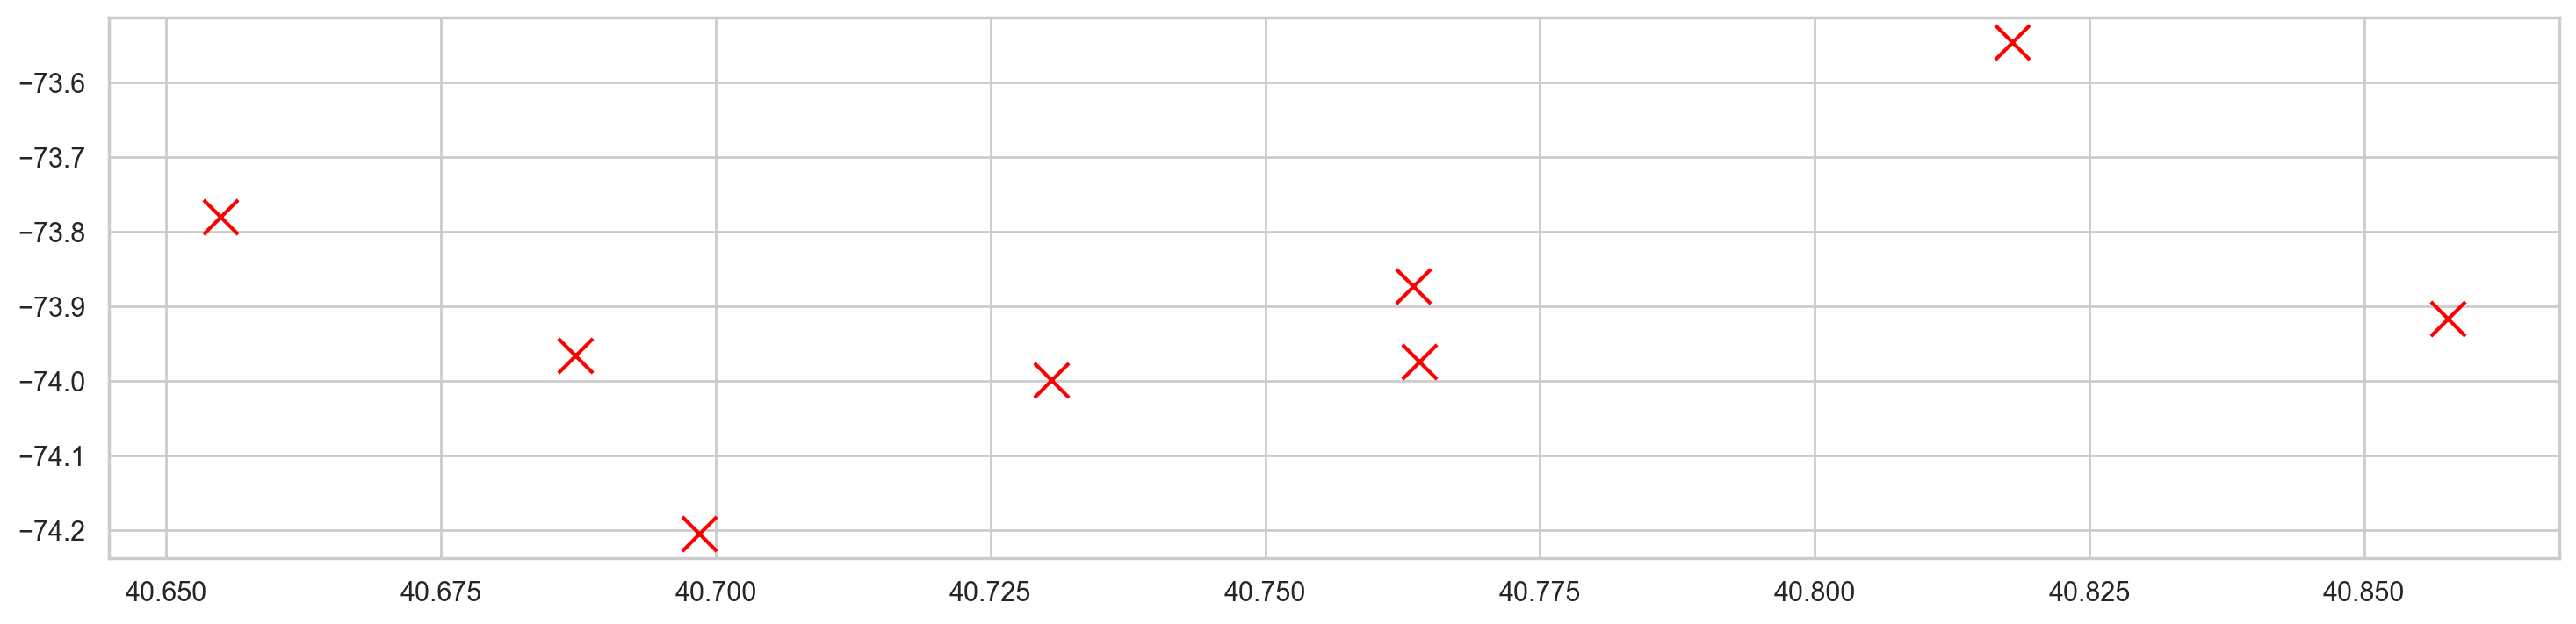

In [48]:
plt.scatter(center_locations["Latitude"],center_locations['Longitude'], marker = 'x', color = 'Red', s = 200)
plt.show();

In [49]:
# Converting centroid into lists
centroid = center_locations.values.tolist()
# Plotting the centroids on google map using Folium library.
map = folium.Map(location=[40.79658011772687, -73.87341741832425], zoom_start = 10)
for point in range(0, len(centroid)):
    folium.Marker(centroid[point], popup = centroid[point]).add_to(map)
map

### 5.2 Predict with k-Means:

In [50]:
test_preds = kmModel.transform(test_df)
test_preds.cache()

DataFrame[dt: string, lat: double, lon: double, Base: string, features: vector, cluster: int]

In [51]:
test_preds.show(10)

+----------------+-------+--------+------+------------------+-------+
|              dt|    lat|     lon|  Base|          features|cluster|
+----------------+-------+--------+------+------------------+-------+
|7/1/2014 0:04:00|40.7107|-73.8444|B02598|[40.7107,-73.8444]|      2|
|7/1/2014 0:05:00|40.7605|-73.9994|B02512|[40.7605,-73.9994]|      0|
|7/1/2014 0:06:00|40.7513|-74.0066|B02598|[40.7513,-74.0066]|      1|
|7/1/2014 0:06:00|40.7636|-73.9755|B02598|[40.7636,-73.9755]|      0|
|7/1/2014 0:09:00|40.7635|-73.9793|B02512|[40.7635,-73.9793]|      0|
|7/1/2014 0:10:00|40.7207|-73.9975|B02598|[40.7207,-73.9975]|      1|
|7/1/2014 0:13:00| 40.662|-73.9872|B02598| [40.662,-73.9872]|      3|
|7/1/2014 0:15:00|40.7708|-73.9619|B02598|[40.7708,-73.9619]|      0|
|7/1/2014 0:17:00|40.7224|-74.0038|B02598|[40.7224,-74.0038]|      1|
|7/1/2014 0:18:00|40.7664|-73.9663|B02598|[40.7664,-73.9663]|      0|
+----------------+-------+--------+------+------------------+-------+
only showing top 10 

In [52]:
print(kmModel.summary.clusterSizes) # No of pints in each cluster

[281385, 291932, 28231, 89107, 2297, 21573, 7266, 12524]


### 5.4 Persist k-means Model:

In [53]:
#kmModel.write().overwrite().save("C:/Users/saivi/spark-3.5.3-bin-hadoop3/project/model")
#kmModel.write().overwrite().save("file:///C:/Users/saivi/spark-3.5.3-bin-hadoop3/project/model")


##   Data Exploration

We can use Spark SQL to explore the dataset. Here are some example queries using the Spark SQL. We will also replicate the same results that we get using Spark SQL by calling the Spark Dataframe APIs directly.

In [60]:
from pyspark.sql.functions import col, to_timestamp
import re
from pyspark.sql.functions import col, to_timestamp, hour, udf
import matplotlib.pyplot as plt
import seaborn as sns

test_preds.createOrReplaceTempView("test_preds")

In [61]:
import re

def strip_margin(text):
    nomargin = re.sub('\n[ \t]*\|', ' ', text)  # Remove leading '|'
    trimmed = re.sub('\s+', ' ', nomargin)  # Replace multiple spaces with a single space
    return trimmed

### Which hours of the day and which cluster had the highest number of pickups?

+----+-------+------+
|hour|cluster| count|
+----+-------+------+
|NULL|      1|124566|
|NULL|      0|120476|
|NULL|      3| 38212|
|NULL|      2| 12110|
|NULL|      5|  9301|
|NULL|      7|  5359|
|NULL|      6|  3216|
|NULL|      4|  1020|
+----+-------+------+



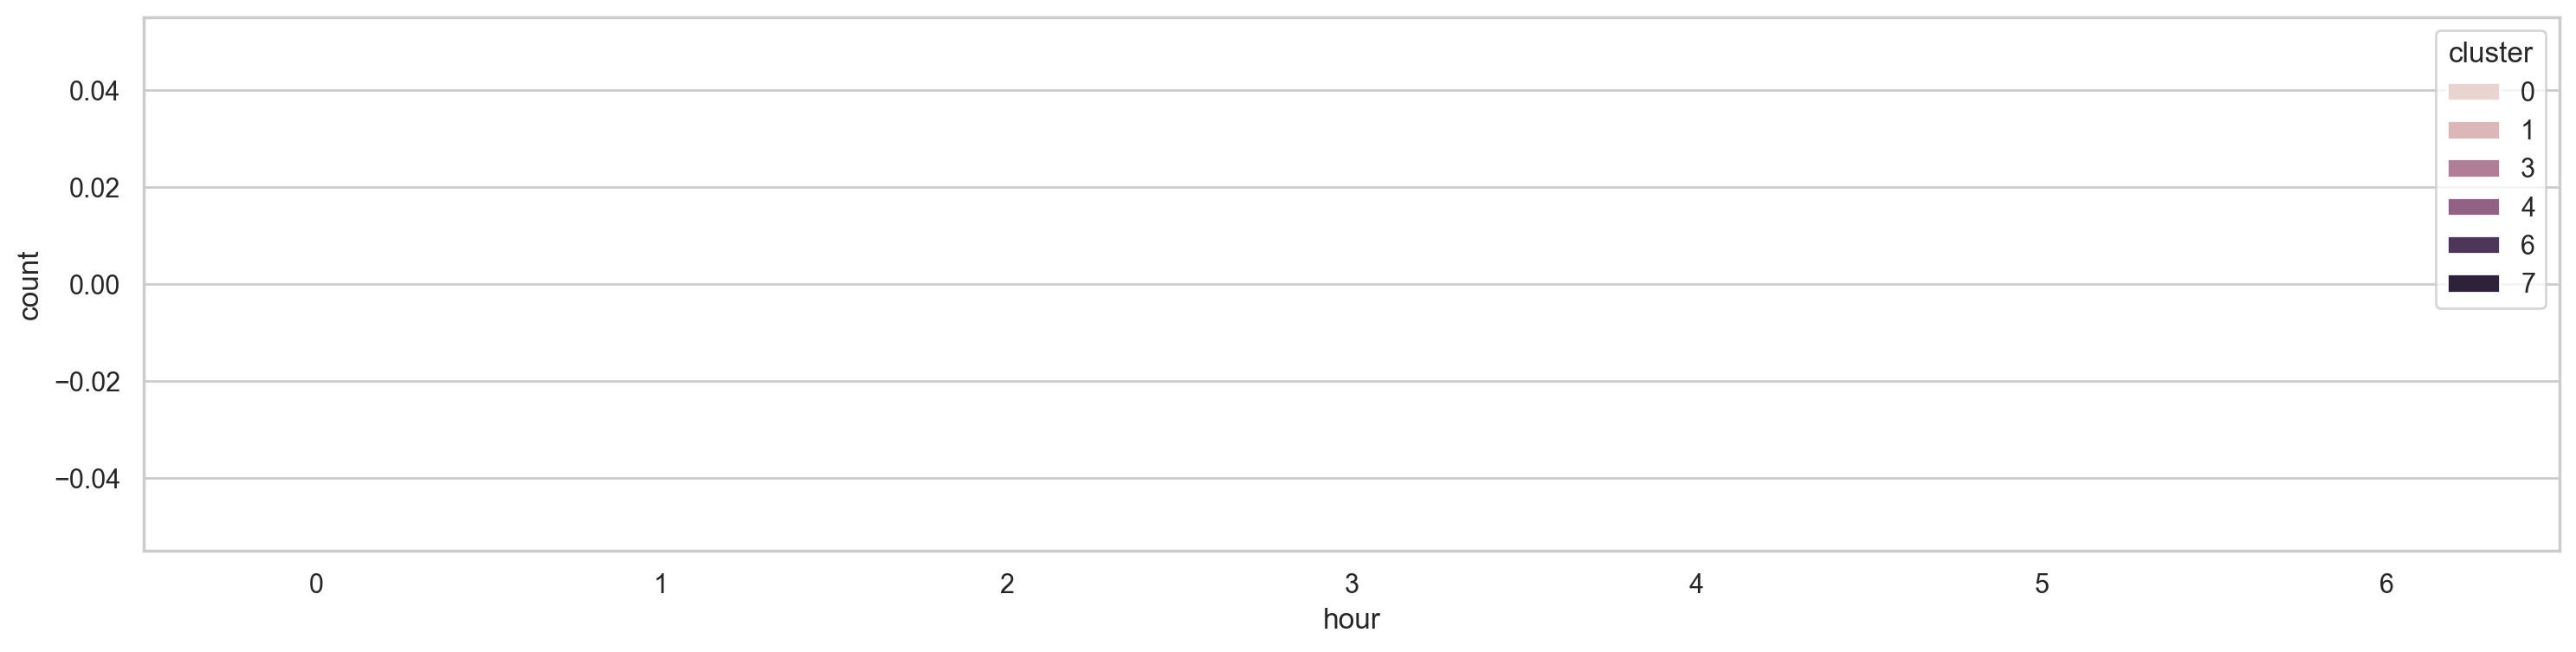

In [62]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT 
                          |    HOUR(dt) AS hour, 
                          |    cluster,
                          |    COUNT(*) as count
                          |FROM test_preds
                          |GROUP BY hour, cluster
                          |ORDER BY count DESC
                        """))
sql_result_df.cache()

sql_result_df.show(10)

plt.figure(figsize=(18,4))
sns.barplot(x="hour", y="count", hue="cluster", data=sql_result_df.toPandas());

In [63]:
(test_preds
    .select(F.hour("dt").alias("hour"), "cluster")
    .groupBy(["hour", "cluster"])
    .count()
    .orderBy(F.desc("count"))).show(10)

+----+-------+------+
|hour|cluster| count|
+----+-------+------+
|NULL|      1|124566|
|NULL|      0|120476|
|NULL|      3| 38212|
|NULL|      2| 12110|
|NULL|      5|  9301|
|NULL|      7|  5359|
|NULL|      6|  3216|
|NULL|      4|  1020|
+----+-------+------+



### How many pickups occurred in each cluster?

+-------+------+
|cluster| count|
+-------+------+
|      0|120476|
|      1|124566|
|      2| 12110|
|      3| 38212|
|      4|  1020|
|      5|  9301|
|      6|  3216|
|      7|  5359|
+-------+------+



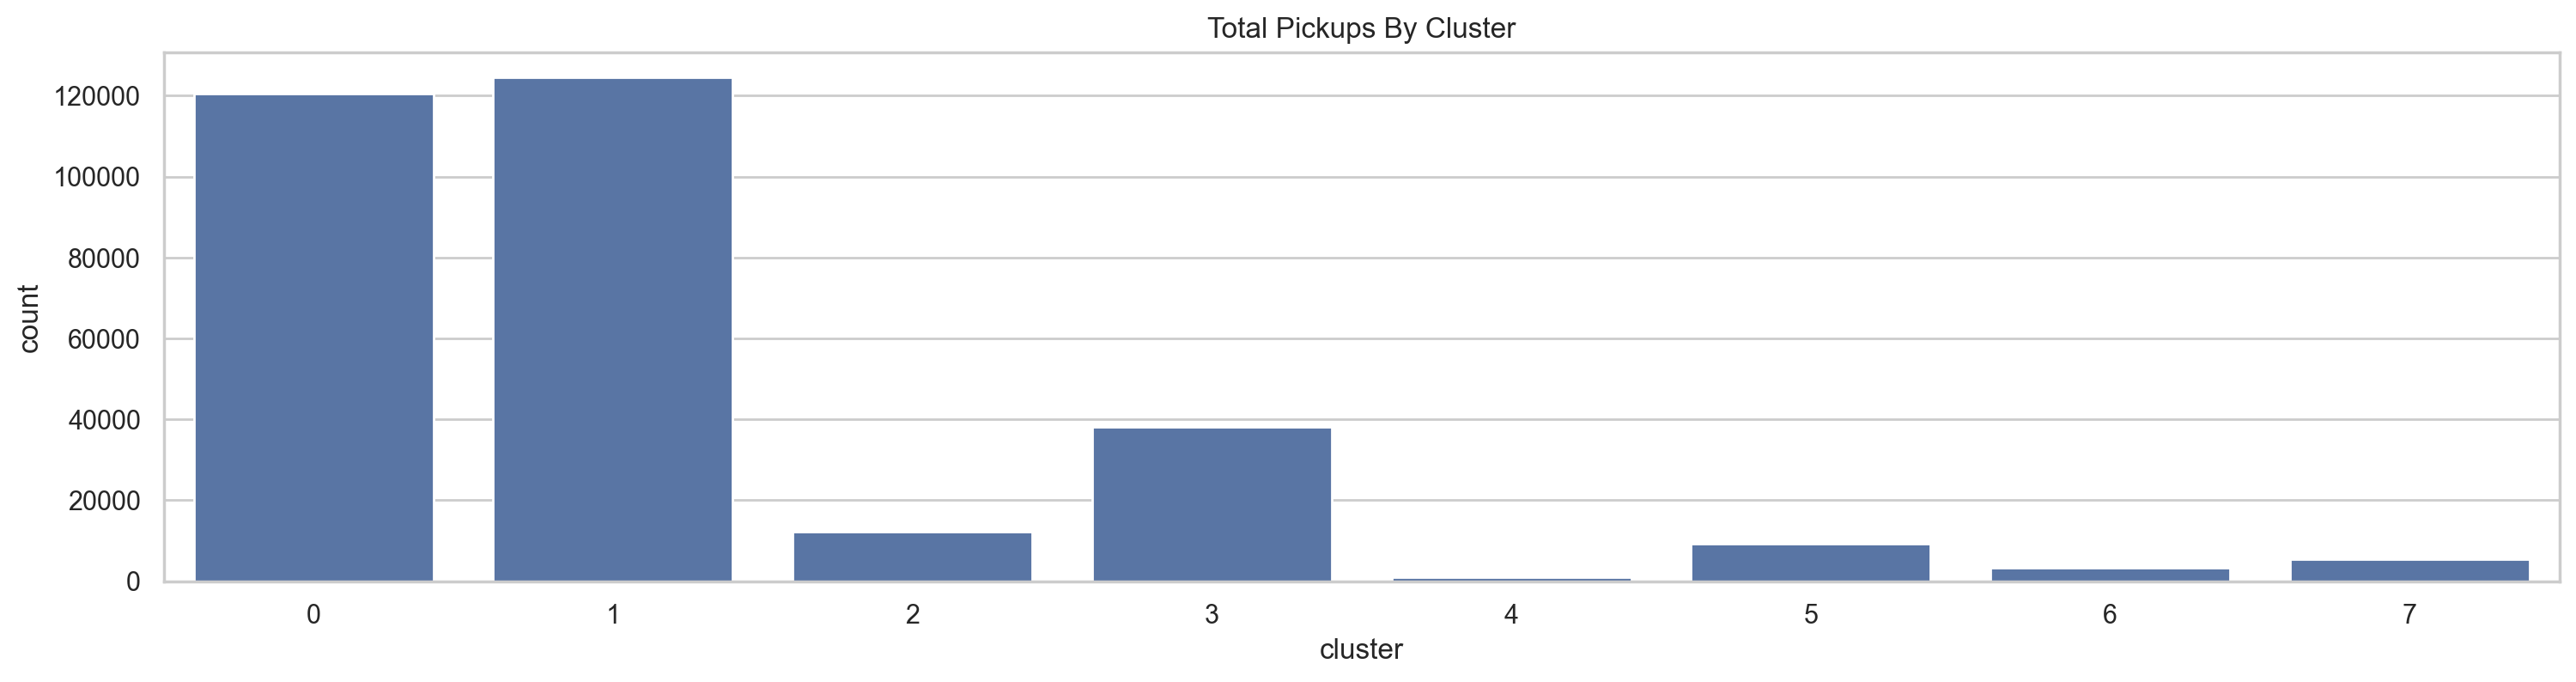

In [104]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT cluster, COUNT(cluster) AS count
                          |FROM test_preds
                          |GROUP BY cluster
                          |ORDER BY cluster
                        """))
sql_result_df.cache()

sql_result_df.show(10)

plt.figure(figsize=(18,4))
sns.barplot(x="cluster", y="count", data=sql_result_df.toPandas())
plt.title("Total Pickups By Cluster");

In [86]:
(test_preds
    .groupBy("cluster")
    .count()
    .orderBy("cluster")).show(10)

+-------+------+
|cluster| count|
+-------+------+
|      0|120476|
|      1|124566|
|      2| 12110|
|      3| 38212|
|      4|  1020|
|      5|  9301|
|      6|  3216|
|      7|  5359|
+-------+------+



###  How many pickups occurred in each hour?

+----+-----+
|hour|count|
+----+-----+
|   0| 6974|
|   1| 4362|
|   2| 3217|
|   3| 3486|
|   4| 3824|
|   5| 5749|
|   6| 9463|
|   7|13391|
|   8|13279|
|   9|11384|
+----+-----+
only showing top 10 rows



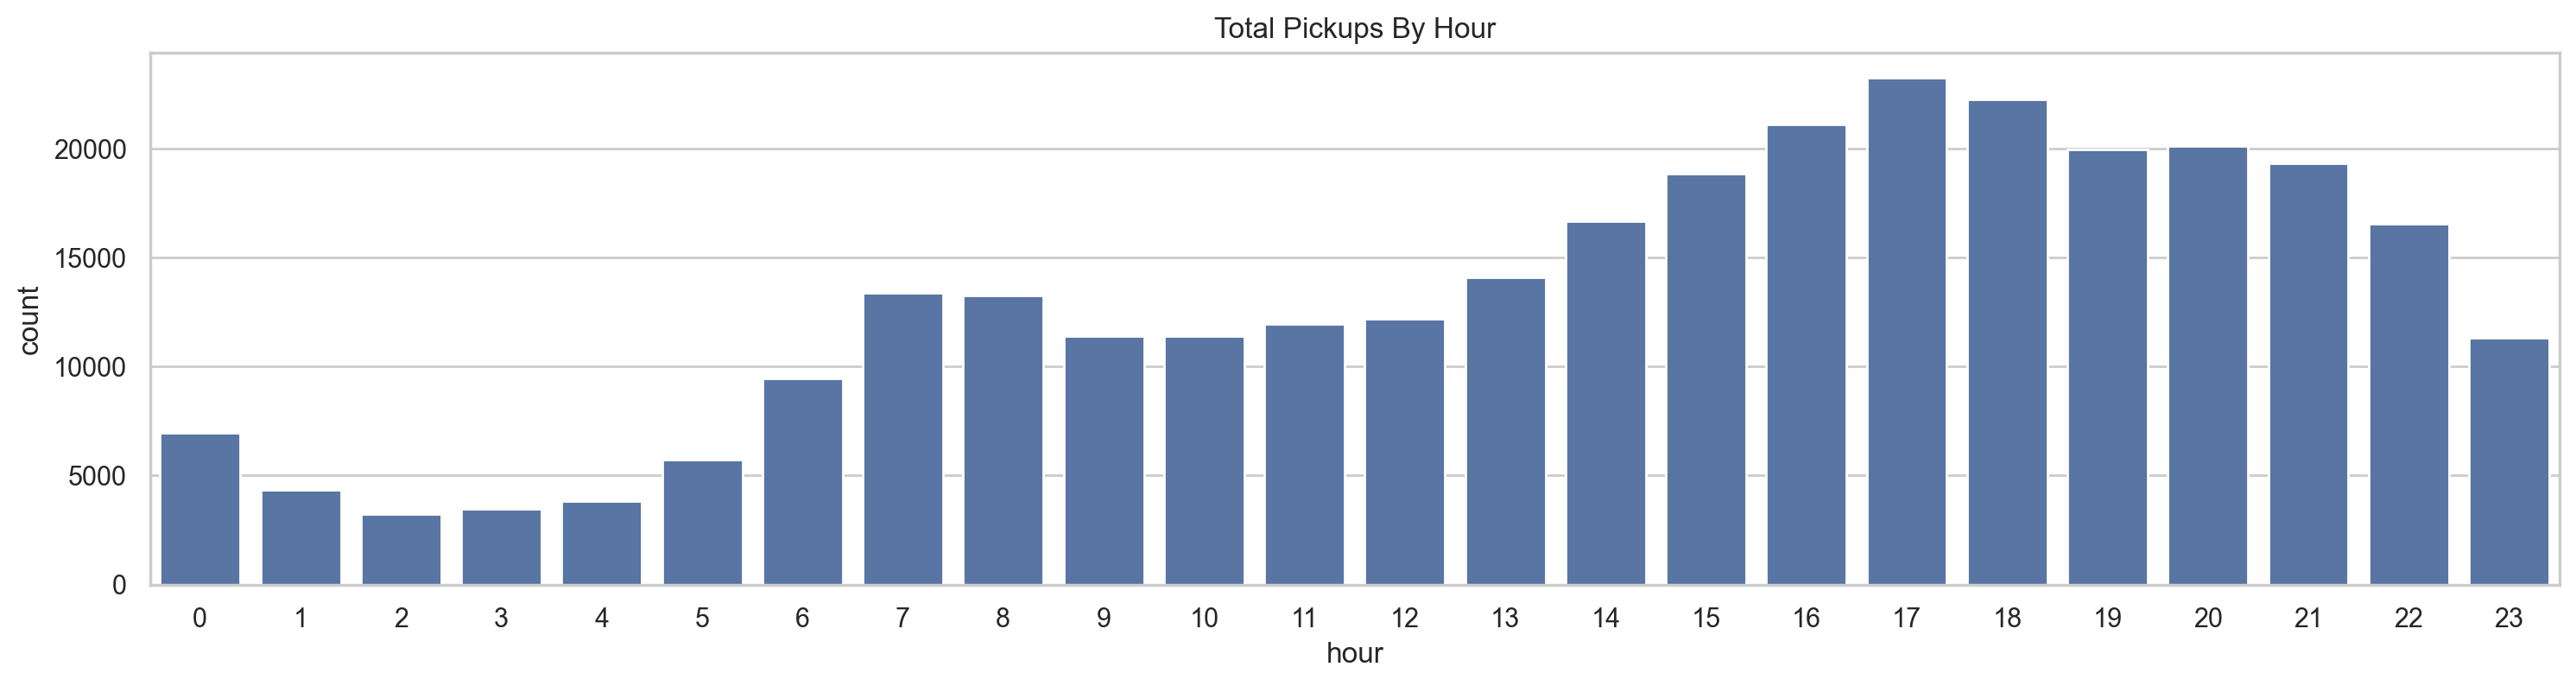

In [105]:
sql_result_df = spark.sql(strip_margin(
                        """SELECT 
                          |    HOUR(dt) AS hour, 
                          |    COUNT(cluster) AS count
                          |FROM test_preds
                          |GROUP BY hour
                          |ORDER BY hour
                        """))
sql_result_df.cache()

sql_result_df.show(10)

plt.figure(figsize=(18,4))
sns.barplot(x="hour", y="count", data=sql_result_df.toPandas())
plt.title("Total Pickups By Hour");


In [91]:
(test_preds
    .select(F.hour("dt").alias("hour"))
    .groupBy("hour")
    .count()
    .orderBy("hour")).show(10)

+----+-----+
|hour|count|
+----+-----+
|   0| 6974|
|   1| 4362|
|   2| 3217|
|   3| 3486|
|   4| 3824|
|   5| 5749|
|   6| 9463|
|   7|13391|
|   8|13279|
|   9|11384|
+----+-----+
only showing top 10 rows



+-----------+-------+-----+
|time_of_day|cluster|count|
+-----------+-------+-----+
|  Afternoon|      0|34040|
|  Afternoon|      1|31996|
|  Afternoon|      3| 8375|
|  Afternoon|      2| 3116|
|  Afternoon|      5| 2661|
|  Afternoon|      7| 1423|
|  Afternoon|      6| 1012|
|  Afternoon|      4|  315|
|    Evening|      0|35207|
|    Evening|      1|34391|
|    Evening|      3| 8419|
|    Evening|      2| 3232|
|    Evening|      5| 2265|
|    Evening|      7| 1147|
|    Evening|      6|  698|
|    Evening|      4|  251|
|    Morning|      0|30715|
|    Morning|      1|27672|
|    Morning|      3|10741|
|    Morning|      2| 3261|
+-----------+-------+-----+
only showing top 20 rows



<Figure size 1200x600 with 0 Axes>

<Axes: xlabel='time_of_day', ylabel='count'>

Text(0.5, 1.0, 'Cluster Distribution by Time of Day')

Text(0.5, 0, 'Time of Day')

Text(0, 0.5, 'Number of Pickups')

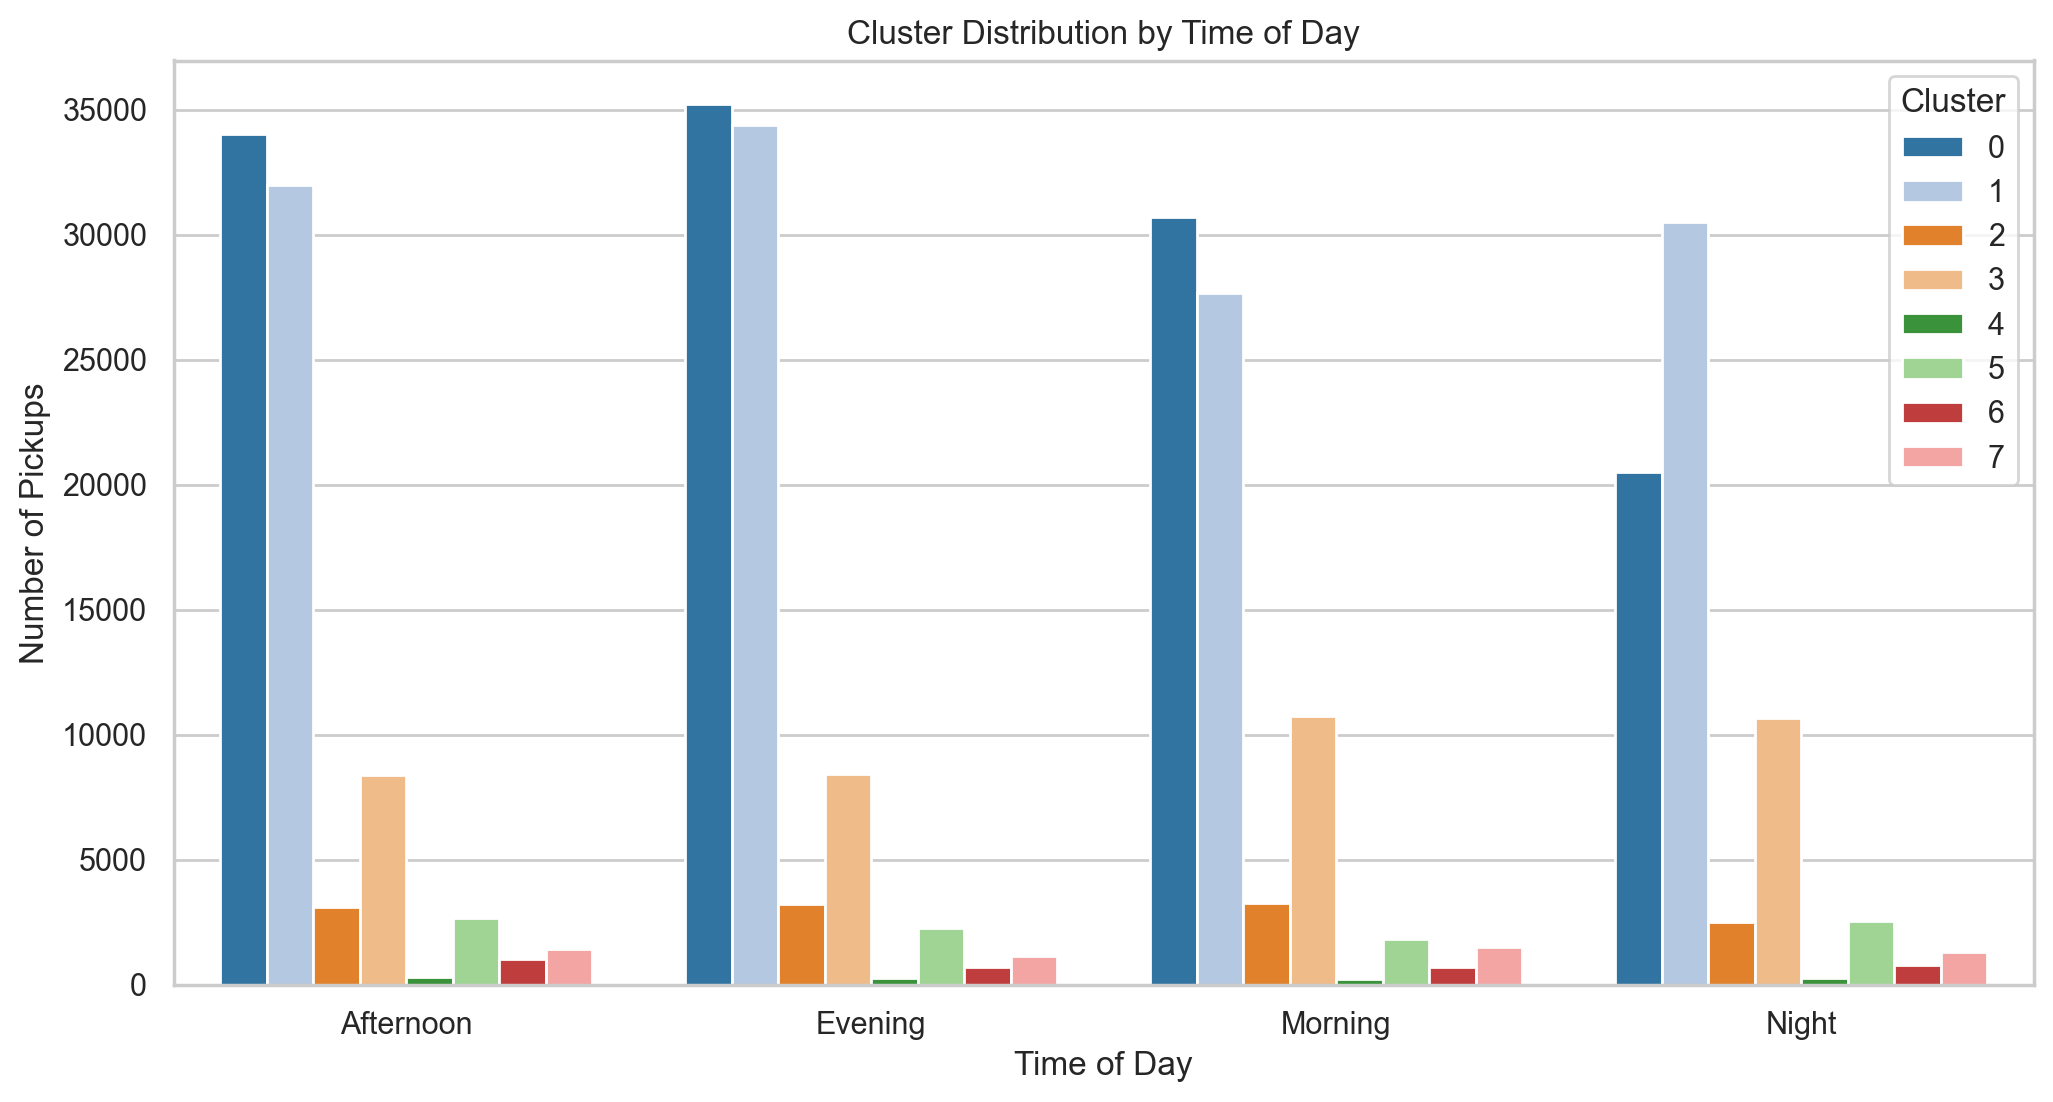

In [108]:
from pyspark.sql.functions import col, to_timestamp, hour, udf
from pyspark.sql.types import StringType
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Convert `dt` column to timestamp format
test_preds = test_preds.withColumn("dt", to_timestamp(col("dt"), "M/d/yyyy H:mm:ss"))

# Step 2: Extract the `hour` column
test_preds = test_preds.withColumn("hour", hour(col("dt")))

# Step 3: Add `time_of_day` column
def get_time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

# Register UDF for time of day
time_of_day_udf = udf(get_time_of_day, StringType())
test_preds = test_preds.withColumn("time_of_day", time_of_day_udf(col("hour")))

# Step 4: Register DataFrame as a temporary SQL view
test_preds.createOrReplaceTempView("test_preds")

# Step 5: Analyze cluster stability across time periods
cluster_stability_df = spark.sql(
    """
    SELECT time_of_day, cluster, COUNT(*) AS count
    FROM test_preds
    GROUP BY time_of_day, cluster
    ORDER BY time_of_day, count DESC
    """
)

# Step 6: Show the results
cluster_stability_df.show()

# Step 7: Convert the Spark DataFrame to Pandas for visualization
cluster_stability_pd = cluster_stability_df.toPandas()

# Step 8: Plot cluster distribution by time of day
plt.figure(figsize=(12, 6))
sns.barplot(x="time_of_day", y="count", hue="cluster", data=cluster_stability_pd, palette="tab20")
plt.title("Cluster Distribution by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Number of Pickups")
plt.legend(title="Cluster")
plt.show()


## 8. Bisecting k-means
`Bisecting k-means` is a variant of `k-means`. The core difference is that instead of clustering points by starting "bottom-up" and assigning a bunch of different groups in the data, this is a top-down clustering method. This means that it will start by creating a single group and then splitting that group into smaller groups in order to end up with the `k` number of clusters specified by the user. This is usually a faster method than `k-means` and will yield different results.

In [92]:
bkm = BisectingKMeans(featuresCol='features', predictionCol='cluster', maxIter=20, k=8)

In [93]:
bkm.explainParams()

"distanceMeasure: the distance measure. Supported options: 'euclidean' and 'cosine'. (default: euclidean)\nfeaturesCol: features column name. (default: features, current: features)\nk: The desired number of leaf clusters. Must be > 1. (default: 4, current: 8)\nmaxIter: max number of iterations (>= 0). (default: 20, current: 20)\nminDivisibleClusterSize: The minimum number of points (if >= 1.0) or the minimum proportion of points (if < 1.0) of a divisible cluster. (default: 1.0)\npredictionCol: prediction column name. (default: prediction, current: cluster)\nseed: random seed. (default: -6311319853468918464)\nweightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)"

In [94]:
bkmModel = bkm.fit(train_df)

In [95]:
bkmModel.transform(test_df).show(10)

+----------------+-------+--------+------+------------------+-------+
|              dt|    lat|     lon|  Base|          features|cluster|
+----------------+-------+--------+------+------------------+-------+
|7/1/2014 0:04:00|40.7107|-73.8444|B02598|[40.7107,-73.8444]|      6|
|7/1/2014 0:05:00|40.7605|-73.9994|B02512|[40.7605,-73.9994]|      2|
|7/1/2014 0:06:00|40.7513|-74.0066|B02598|[40.7513,-74.0066]|      2|
|7/1/2014 0:06:00|40.7636|-73.9755|B02598|[40.7636,-73.9755]|      2|
|7/1/2014 0:09:00|40.7635|-73.9793|B02512|[40.7635,-73.9793]|      2|
|7/1/2014 0:10:00|40.7207|-73.9975|B02598|[40.7207,-73.9975]|      0|
|7/1/2014 0:13:00| 40.662|-73.9872|B02598| [40.662,-73.9872]|      1|
|7/1/2014 0:15:00|40.7708|-73.9619|B02598|[40.7708,-73.9619]|      3|
|7/1/2014 0:17:00|40.7224|-74.0038|B02598|[40.7224,-74.0038]|      0|
|7/1/2014 0:18:00|40.7664|-73.9663|B02598|[40.7664,-73.9663]|      2|
+----------------+-------+--------+------+------------------+-------+
only showing top 10 

In [96]:
centriods  = bkmModel.clusterCenters()
centriods

[array([ 40.7267, -74.005 ]),
 array([ 40.6867, -73.9663]),
 array([ 40.7571, -73.9807]),
 array([ 40.7876, -73.9527]),
 array([ 40.6554, -73.7822]),
 array([ 40.764 , -73.4972]),
 array([ 40.7686, -73.8646]),
 array([ 40.9813, -73.7729])]

In [97]:
center_locations = pd.DataFrame(centriods)
center_locations.columns=["Latitude", "Longitude"]
center_locations

,Latitude,Longitude
0,40.726718,-74.005049
1,40.686724,-73.966281
2,40.757091,-73.980724
3,40.787609,-73.952681
4,40.655409,-73.782194
5,40.763969,-73.497205
6,40.768595,-73.864626
7,40.981297,-73.772854


In [98]:
# Converting centroid into lists
centroid = center_locations.values.tolist()
# Plotting the centroids on google map using Folium library.
map = folium.Map(location=[40.79658011772687, -73.87341741832425], zoom_start = 10)
for point in range(0, len(centroid)):
    folium.Marker(centroid[point], popup = centroid[point]).add_to(map)
map

### 8.1 Bisecting k-means Summary

`Bisecting k-means` includes a summary class that we can use to evaluate our model, that is largely the same as the `k-means` summary. This includes information about the clusters created, as well as their relative sizes (number of examples):

In [99]:
print(bkmModel.summary.clusterSizes) # number of points

[257512, 86295, 258430, 81804, 21965, 1798, 24544, 1967]


In [100]:
bkmModel.computeCost(train_df)

914.0430931431493

In [101]:
print("Bisecting k-means Cluster Centers: ")
for center in bkmModel.clusterCenters():
    print(center)

Bisecting k-means Cluster Centers: 
[ 40.7267 -74.005 ]
[ 40.6867 -73.9663]
[ 40.7571 -73.9807]
[ 40.7876 -73.9527]
[ 40.6554 -73.7822]
[ 40.764  -73.4972]
[ 40.7686 -73.8646]
[ 40.9813 -73.7729]


In [85]:
spark.stop()